In [1]:
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_problem(n, d, s, std=0.06):

    xsp = 0.5 * (np.random.rand(s // 2) + 1)
    xsn = - 0.5 * (np.random.rand(s // 2) + 1)
    xsparse = np.hstack([xsp, xsn, np.zeros(d - s)])
    random.shuffle(xsparse)
    A = np.random.randn(n, d)
    y = A @ xsparse + std * np.random.randn(n)

    return xsparse, A, y

def f(A, x, y):
    return np.mean(np.square(A@x-y)) / 2

def g(x, lamda):
    return lamda * np.linalg.norm(x, 1)

def F(A, x, y, lamda):
    return f(A, x, y) + g(x, lamda)

@ np.vectorize
def prox_l1(t, gamma):
    return t-gamma if t>gamma else (t+gamma if t<-gamma else 0)

In [3]:
def psga(A, y, lamda, n_iters):

    gamma_0 = A.shape[0] / np.linalg.norm(A, 2)**2
    i_ks = np.random.choice(A.shape[0], n_iters)

    x = np.zeros(A.shape[1])
    Fs = list(); Fs.append(F(A, x, y, lamda))

    em_num, em_den = gamma_0*x, gamma_0
    em_Fs = list(); em_Fs.append(F(A, em_num/em_den, y, lamda))

    for k, i_k in tqdm(enumerate(i_ks), total=n_iters):
        
        gamma_k = gamma_0 / (k+1)**0.5
        t = x - gamma_k * (A[i_k]@x - y[i_k]) * A[i_k]
        
        x = prox_l1(t, gamma_k*lamda)
        Fs.append(F(A, x, y, lamda))
        
        em_num, em_den = em_num+gamma_k*x, em_den+gamma_k
        em_Fs.append(F(A, em_num/em_den, y, lamda))

    return x, Fs, em_Fs

In [33]:
def rcpga(A, y, lamda, n_iters):

    gamma_js = A.shape[0] / np.linalg.norm(A, 2, 0)**2
    j_ks = np.random.choice(A.shape[1], n_iters)

    x = np.zeros(A.shape[1])
    Fs = list(); Fs.append(F(A, x, y, lamda))

    for j_k in j_ks:
        
        gamma_j = gamma_js[j_k]
        t = x[j_k] - gamma_j/A.shape[0] * A[:, j_k] @ (A@x-y)

        x[j_k] = prox_l1(t, gamma_j*lamda)
        Fs.append(F(A, x, y, lamda))

    return x, Fs

In [34]:
n, d, s, std = 1000, 500, 50, 0.06
x_true, A, y = generate_problem(n=n, d=d, s=s, std=std)

In [36]:
n_iters, lamda = 10_000, 0.01
for lamda in (1e-3, 1e-2, 1e-1, 1):
    x_pred, Fs = rcpga(A, y, lamda=lamda, n_iters=n_iters)
    print(f'lambda = {lamda}, sparsity = {(d**0.5 - np.linalg.norm(x_pred, 1)/np.linalg.norm(x_pred, 2)) / (d**0.5 - 1)}')

lambda = 0.001, sparsity = 0.707562657937286
lambda = 0.01, sparsity = 0.7213054769310091
lambda = 0.1, sparsity = 0.7232093827734442
lambda = 1, sparsity = 0.9421406799849024


C:\Users\Jasraj\AppData\Local\Temp\ipykernel_3472\255691270.py:4: RuntimeWarning: invalid value encountered in double_scalars
  print(f'lambda = {lamda}, sparsity = {(d**0.5 - np.linalg.norm(x_pred, 1)/np.linalg.norm(x_pred, 2)) / (d**0.5 - 1)}')


lambda = 10, sparsity = nan
lambda = 100, sparsity = nan


100%|██████████| 10000/10000 [00:03<00:00, 3055.52it/s]


[0. 0.]


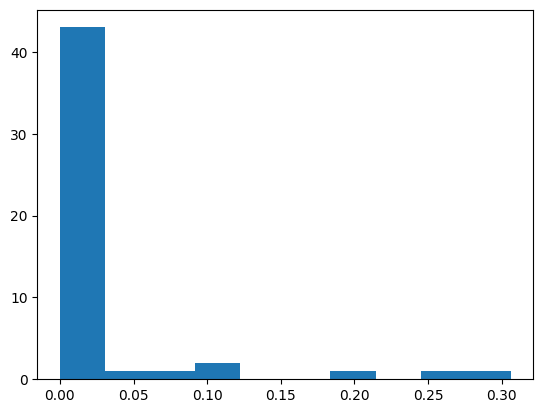

In [30]:
x_pred, Fs = rcpga(A, y, lamda=1, n_iters=n_iters)
x_pred = np.sort(np.abs(x_pred))
print(x_pred[449:451])
plt.hist(x_pred[-50:])
plt.show()

In [31]:
np.count_nonzero(x_pred)

7

In [71]:
x = np.arange(-2.0, 2.0, 0.0025)
y = np.arange(-2.0, 2.0, 0.0025)
X, Y = np.meshgrid(x, y)

x, A, y = generate_problem(100, 2, 2, std)
grid = np.stack((X, Y), axis=2)

In [72]:
F_grid = np.mean(np.square(np.apply_along_axis(lambda x: A@x, axis=2, arr=grid)-y), 2) + 0.1 * np.linalg.norm(grid, 1, 2)

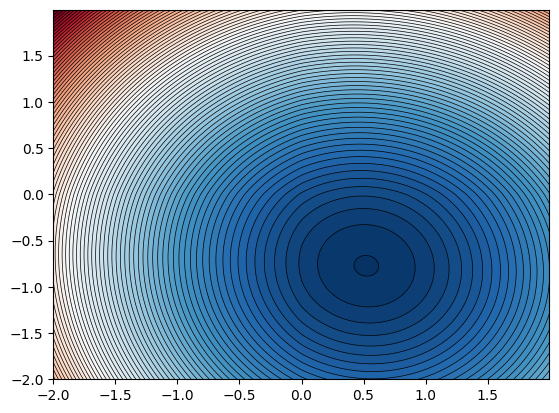

In [75]:
fig, ax = plt.subplots()
ax.contour(X, Y, F_grid, levels=100, linewidths=0.5, colors='k')
cntr1 = ax.contourf(X, Y, F_grid, levels=100, cmap="RdBu_r")
plt.show()